In [1]:
import os
#os.environ["TRITON_INTERPRET"] = "1"
os.environ["TRITON_PRINT_AUTOTUNING"] = "1"
import math
import torch
import torch.nn as nn
import triton
import triton.language as tl
from triton.language.extra import libdevice
from flash_attn.flash_attn_interface import flash_attn_qkvpacked_func as flash_attn_func

torch.manual_seed(0)
device = torch.device("cuda:6")
torch.cuda.set_device(device)

In [2]:
def my_scaled_dot_product_attention(Q, K, V, is_causal=False):
    if is_causal:
        mask = torch.ones(Q.size(1), K.size(1)) * float("-inf")
        mask = torch.triu(mask, diagonal=1)
    attn = Q @ K.transpose(-2, -1)
    attn = attn.to(torch.float32)
    attn = attn / math.sqrt(Q.size(-1))
    if is_causal:
        attn += mask
    attn = torch.softmax(attn, dim=-1)
    attn = attn.to(torch.float16)
    attn = attn @ V
    return attn


def my_scaled_sigmoid_dot_product_attention(Q, K, V, is_causal=False):
    if is_causal:
        mask = torch.ones(Q.size(1), K.size(1)) * float("-inf")
        mask = torch.triu(mask, diagonal=1)
    attn = Q @ K.transpose(-2, -1)
    attn = attn.to(torch.float32)
    attn = attn / math.sqrt(Q.size(-1))
    if is_causal:
        attn += mask
    attn = torch.sigmoid(attn)
    attn = attn.to(torch.float16)
    attn = attn @ V
    return attn

In [3]:
configs = [
    triton.Config({'Q_BLOCK_SIZE': BM, 'KV_BLOCK_SIZE': BN}, num_stages=s, num_warps=w) 
    for BM in [64, 128]
    for BN in [32, 64]
    for s in [3, 4, 7]
    for w in [4, 8]
]

@triton.autotune(configs, key=["seq_len", "embed_dim"])
@triton.jit
def flash_attention(q_ptr, k_ptr, v_ptr, o_ptr, seq_len, attn_norm, embed_dim, embed_dim_block: tl.constexpr, EMBED_DIM_IS_EVEN: tl.constexpr, Q_BLOCK_SIZE: tl.constexpr, KV_BLOCK_SIZE: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)

    if EMBED_DIM_IS_EVEN:
        embed_dim = embed_dim_block  # hint to compiler they are the same value to simplify mask calculation

    q_block_ptr = tl.make_block_ptr(
        base=q_ptr + pid_1 * seq_len * embed_dim,
        shape=(seq_len, embed_dim),
        strides=(embed_dim, 1),
        offsets=(pid_0 * Q_BLOCK_SIZE, 0),
        block_shape=(Q_BLOCK_SIZE, embed_dim_block),
        order=(1, 0),
    )
    # loading a block pointer with reverted order results in less memory movement and better runtime as compared to transposing later on
    k_block_ptr = tl.make_block_ptr(
        base=k_ptr + pid_1 * seq_len * embed_dim,
        shape=(embed_dim, seq_len),
        strides=(1, embed_dim),
        offsets=(0, 0),
        block_shape=(embed_dim_block, KV_BLOCK_SIZE),
        order=(0, 1),
    )
    v_block_ptr = tl.make_block_ptr(
        base=v_ptr + pid_1 * seq_len * embed_dim,
        shape=(seq_len, embed_dim),
        strides=(embed_dim, 1),
        offsets=(0, 0),
        block_shape=(KV_BLOCK_SIZE, embed_dim_block),
        order=(1, 0),
    )
    o_block_ptr = tl.make_block_ptr(
        base=o_ptr + pid_1 * seq_len * embed_dim,
        shape=(seq_len, embed_dim),
        strides=(embed_dim, 1),
        offsets=(pid_0 * Q_BLOCK_SIZE, 0),
        block_shape=(Q_BLOCK_SIZE, embed_dim_block),
        order=(1, 0),
    )
    
    q = tl.load(q_block_ptr)
    attn_norm = attn_norm.to(tl.float16)  
    q = q * attn_norm  # precompute softmax scaling on Q so we don't have to do it inside the loop
    m = tl.full((Q_BLOCK_SIZE,), -float("inf"), dtype=tl.float32)
    l = tl.zeros((Q_BLOCK_SIZE,), dtype=tl.float32)
    o = tl.zeros((Q_BLOCK_SIZE, embed_dim_block), dtype=tl.float32)
        
    for i in range(0, seq_len, KV_BLOCK_SIZE):
        seq_len = tl.multiple_of(seq_len, KV_BLOCK_SIZE)
        k = tl.load(k_block_ptr)
        v = tl.load(v_block_ptr)
        
        s = tl.dot(q, k)
        old_m = m
        m = tl.maximum(m, tl.max(s, -1))
        s = s - m[:, None]
        p = tl.exp2(s)  # Use exp2 to match GPU implementation. Log2e gets folded into softmax scale to save computation
        m_shift = tl.exp2(old_m - m)
        l = l * m_shift + tl.sum(p, -1)   
        p = p.to(tl.float16)
        o = o * m_shift[:, None]
        o += tl.dot(p, v)

        k_block_ptr = tl.advance(k_block_ptr, (0, KV_BLOCK_SIZE))
        v_block_ptr = tl.advance(v_block_ptr, (KV_BLOCK_SIZE, 0))
        
    o = o / l[:, None]
    o = o.to(tl.float16)

    tl.store(o_block_ptr, o)
        

In [4]:
def apply_flash_attention(q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, attn_norm):
    batch_size = q.size(0)
    num_heads = q.size(1)
    seq_len = q.size(2)
    embed_dim = q.size(3)
    batch_size_gemm = batch_size * num_heads
    embed_dim_block = triton.next_power_of_2(embed_dim)
    if embed_dim == embed_dim_block:
        EMBED_DIM_EVEN = True
    else:
        EMBED_DIM_EVEN = False
    o = torch.empty_like(q)
    # launching programs in batch minor order results in more KV data going through L2 cache and significantly better L2 cache hit rates
    grid = lambda args: (triton.cdiv(seq_len, args["Q_BLOCK_SIZE"]), batch_size_gemm)
    kernel = flash_attention[grid](q, k, v, o, seq_len, attn_norm, embed_dim, embed_dim_block, EMBED_DIM_EVEN) 
    #print(kernel.asm['ttir'])
    return o

In [5]:
batch_size = 4
num_heads = 32
seq_len = 4096
embed_dim = 64
log2_e = 1.44269504
attn_norm = log2_e / math.sqrt(embed_dim)
#attn_norm = torch.tensor(attn_norm, dtype=torch.float16, device=device)

q = torch.randn((batch_size, num_heads, seq_len, embed_dim), device=device, dtype=torch.float16)
k = torch.randn((batch_size, num_heads, seq_len, embed_dim), device=device, dtype=torch.float16)
v = torch.randn((batch_size, num_heads, seq_len, embed_dim), device=device, dtype=torch.float16)

output_torch = my_scaled_dot_product_attention(q, k, v) #.transpose(0, 1)
output_triton = apply_flash_attention(q, k, v, attn_norm) #.transpose(0, 1)
print(output_torch.size())
print(output_triton.size())
print(output_torch.dtype)
print(output_triton.dtype)

print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')
print(f'The mean difference between torch and triton is '
      f'{torch.mean(torch.abs(output_torch - output_triton))}')
print(output_torch == output_triton)
#print(q[0, 0, 0])
print(output_torch[0, 0])
print(output_triton[0, 0])
#print(output_torch[0, 2] == output_triton[0, 2])

Autotuning kernel flash_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel flash_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 8, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel flash_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None
Autotuning kernel flash_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 8, num_ctas: 1, num_stages: 4, maxnreg: None
Autotuning kernel flash_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 4, num_ctas: 1, num_stages: 7, maxnreg: None
Autotuning kernel flash_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 8, num_ctas: 1, num_stages: 7, maxnreg: None
Autotuning kernel flash_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 64, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel flash_att

In [6]:
configs = [
    triton.Config({'Q_BLOCK_SIZE': BM, 'KV_BLOCK_SIZE': BN}, num_stages=s, num_warps=w) 
    for BM in [64, 128]
    for BN in [32, 64]
    for s in [3, 4, 7]
    for w in [4, 8]
]

@triton.autotune(configs, key=["seq_len", "embed_dim"])
@triton.jit
def flash_sigmoid_attention(q_ptr, k_ptr, v_ptr, o_ptr, batch_size, seq_len, attn_norm, embed_dim, embed_dim_block: tl.constexpr, EMBED_DIM_IS_EVEN: tl.constexpr, Q_BLOCK_SIZE: tl.constexpr, KV_BLOCK_SIZE: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)

    if EMBED_DIM_IS_EVEN:
        embed_dim = embed_dim_block  # set embed_dim and embed_dim_block to be the same constant to simplify mask calculations

    
    q_block_ptr = tl.make_block_ptr(
        base=q_ptr + pid_1 * seq_len * embed_dim,
        shape=(seq_len, embed_dim),
        strides=(embed_dim, 1),
        offsets=(pid_0 * Q_BLOCK_SIZE, 0),
        block_shape=(Q_BLOCK_SIZE, embed_dim_block),
        order=(1, 0),
    )
    k_block_ptr = tl.make_block_ptr(
        base=k_ptr + pid_1 * seq_len * embed_dim,
        shape=(embed_dim, seq_len),
        strides=(1, embed_dim),
        offsets=(0, 0),
        block_shape=(embed_dim_block, KV_BLOCK_SIZE),
        order=(0, 1),
    )
    v_block_ptr = tl.make_block_ptr(
        base=v_ptr + pid_1 * seq_len * embed_dim,
        shape=(seq_len, embed_dim),
        strides=(embed_dim, 1),
        offsets=(0, 0),
        block_shape=(KV_BLOCK_SIZE, embed_dim_block),
        order=(1, 0),
    )
    o_block_ptr = tl.make_block_ptr(
        base=o_ptr + pid_1 * seq_len * embed_dim,
        shape=(seq_len, embed_dim),
        strides=(embed_dim, 1),
        offsets=(pid_0 * Q_BLOCK_SIZE, 0),
        block_shape=(Q_BLOCK_SIZE, embed_dim_block),
        order=(1, 0),
    )
    
    q = tl.load(q_block_ptr)
    attn_norm = attn_norm.to(tl.float16)
    q = q * attn_norm
    o = tl.zeros((Q_BLOCK_SIZE, embed_dim_block), dtype=tl.float32)
    
    for i in range(0, seq_len, KV_BLOCK_SIZE):
        k = tl.load(k_block_ptr)
        v = tl.load(v_block_ptr)
        #s = tl.dot(q, k.trans(1, 0)) * attn_norm
        s = tl.dot(q, k) 
        p = 1.0 / (1.0 + tl.exp2(s))  #tl.sigmoid(s)
        #print(s.shape)

        #v = tl.load(v_ptr + kv_offsets, mask=kv_mask)
        #v = tl.load(v_block_ptr)
        p = p.to(tl.float16)
        o = tl.dot(p, v, o)

        #m = mi
        k_block_ptr = tl.advance(k_block_ptr, (0, KV_BLOCK_SIZE))
        v_block_ptr = tl.advance(v_block_ptr, (KV_BLOCK_SIZE, 0))
        
    o = o.to(tl.float16)

    #o_start = pid_0 * Q_BLOCK_SIZE * embed_dim
    #o_offsets = o_start + (tl.arange(0, BATCH_BLOCK_SIZE)[:, None, None] * seq_len * embed_dim + tl.arange(0, Q_BLOCK_SIZE)[None, :, None] * embed_dim + tl.arange(0, EMBED_BLOCK_SIZE)[None, None, :])
    #o_mask = (tl.arange(0, BATCH_BLOCK_SIZE)[:, None, None] < batch_size) & (pid_0 * Q_BLOCK_SIZE + tl.arange(0, Q_BLOCK_SIZE)[None, :, None] < seq_len) & (tl.arange(0, EMBED_BLOCK_SIZE)[None, None, :] < embed_dim)
    
    #tl.store(o_ptr + q_offsets, o, mask=q_mask)
    tl.store(o_block_ptr, o)
    

In [7]:
def apply_flash_sigmoid_attention(q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, attn_norm):
    batch_size = q.size(0)
    num_heads = q.size(1)
    seq_len = q.size(2)
    embed_dim = q.size(3)
    embed_dim_block = triton.next_power_of_2(embed_dim)
    if embed_dim == embed_dim_block:
        EMBED_DIM_EVEN = True
    else:
        EMBED_DIM_EVEN = False
    batch_size_gemm = batch_size * num_heads
    o = torch.empty_like(q)
    grid = lambda args: (triton.cdiv(seq_len, args["Q_BLOCK_SIZE"]), batch_size_gemm)
    kernel = flash_sigmoid_attention[grid](q, k, v, o, batch_size_gemm, seq_len, attn_norm, embed_dim, embed_dim_block, EMBED_DIM_EVEN)
    #print(kernel.asm['ttir'])
    return o
    

In [8]:
batch_size = 4
num_heads = 32
seq_len = 1024
embed_dim = 64
log2_e = 1.44269504
attn_norm = -log2_e / math.sqrt(embed_dim)

q = torch.randn((batch_size, num_heads, seq_len, embed_dim), device=device, dtype=torch.float16)
k = torch.randn((batch_size, num_heads, seq_len, embed_dim), device=device, dtype=torch.float16)
v = torch.randn((batch_size, num_heads, seq_len, embed_dim), device=device, dtype=torch.float16)

output_torch = my_scaled_sigmoid_dot_product_attention(q, k, v) #.transpose(0, 1)
output_triton = apply_flash_sigmoid_attention(q, k, v, attn_norm) #.transpose(0, 1)
print(output_torch.size())
print(output_triton.size())
print(output_torch.dtype)
print(output_triton.dtype)

print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')
print(f'The mean difference between torch and triton is '
      f'{torch.mean(torch.abs(output_torch - output_triton))}')
print(output_torch == output_triton)
print(output_torch[0, 0])
print(output_triton[0, 0])
#print(output_torch[0, 2] == output_triton[0, 2])


Autotuning kernel flash_sigmoid_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel flash_sigmoid_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 8, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel flash_sigmoid_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None
Autotuning kernel flash_sigmoid_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 8, num_ctas: 1, num_stages: 4, maxnreg: None
Autotuning kernel flash_sigmoid_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 4, num_ctas: 1, num_stages: 7, maxnreg: None
Autotuning kernel flash_sigmoid_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 8, num_ctas: 1, num_stages: 7, maxnreg: None
Autotuning kernel flash_sigmoid_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 64, num_warps: 4, num_ctas: 1, 

In [9]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range (9, 15, 1)],  # Different possible values for `x_name`.
        #x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['flash', 'triton_softmax', 'triton_sigmoid'],  # Possible values for `line_arg`.
        line_names=['Flash', 'Triton softmax', 'Triton sigmoid'],  # Label name for the lines.
        styles=[('green', '-'), ('blue', '-'), ('red', '-')],  # Line styles.
        ylabel='TFLOPS',  # Label name for the y-axis.
        plot_name='flash-attn-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    batch_size = 4
    num_heads = 32
    seq_len = size
    embed_dim = 128
    log2_e = 1.44269504
    attn_norm = log2_e / math.sqrt(embed_dim)
    if provider == 'flash':
        qkv = torch.randn((batch_size, seq_len, 3, num_heads, embed_dim), dtype=torch.float16, device=device)
        fn = lambda: flash_attn_func(qkv)
        ms = triton.testing.do_bench(fn)
    if provider == 'triton_softmax':
        q = torch.randn((batch_size, num_heads, seq_len, embed_dim), device=device, dtype=torch.float16)
        k = torch.randn((batch_size, num_heads, seq_len, embed_dim), device=device, dtype=torch.float16)
        v = torch.randn((batch_size, num_heads, seq_len, embed_dim), device=device, dtype=torch.float16)
        ms = triton.testing.do_bench(lambda: apply_flash_attention(q, k, v, attn_norm))
    if provider == 'triton_sigmoid':
        attn_norm_sigmoid = - attn_norm
        q = torch.randn((batch_size, num_heads, seq_len, embed_dim), device=device, dtype=torch.float16)
        k = torch.randn((batch_size, num_heads, seq_len, embed_dim), device=device, dtype=torch.float16)
        v = torch.randn((batch_size, num_heads, seq_len, embed_dim), device=device, dtype=torch.float16)
        ms = triton.testing.do_bench(lambda: apply_flash_sigmoid_attention(q, k, v, attn_norm_sigmoid))

    flops_per_matmul = 2.0 * batch_size * num_heads * seq_len * seq_len * embed_dim
    total_flops = 2 * flops_per_matmul
    return total_flops * 1e-12 / (ms * 1e-3)


Autotuning kernel flash_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel flash_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 8, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel flash_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None
Autotuning kernel flash_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 8, num_ctas: 1, num_stages: 4, maxnreg: None
Autotuning kernel flash_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 4, num_ctas: 1, num_stages: 7, maxnreg: None
Autotuning kernel flash_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 32, num_warps: 8, num_ctas: 1, num_stages: 7, maxnreg: None
Autotuning kernel flash_attention with config Q_BLOCK_SIZE: 64, KV_BLOCK_SIZE: 64, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel flash_att

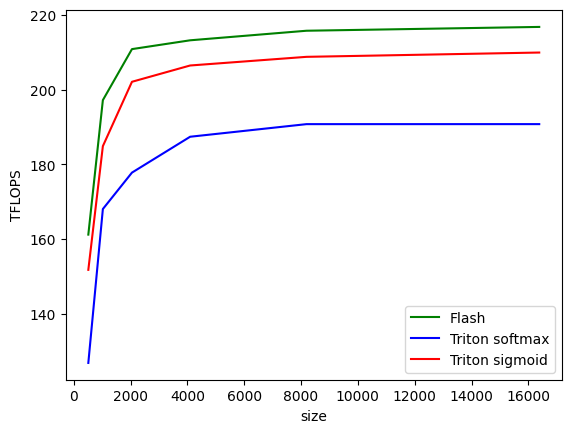

flash-attn-performance:
      size       Flash  Triton softmax  Triton sigmoid
0    512.0  161.207526      126.884806      151.784445
1   1024.0  197.187537      168.056774      184.875439
2   2048.0  210.833889      177.795375      202.092612
3   4096.0  213.190950      187.391424      206.451322
4   8192.0  215.748900      190.762378      208.767185
5  16384.0  216.769739      190.766615      209.917637


In [10]:
benchmark.run(print_data=True, show_plots=True)